In [1]:
import pandas as pd
import numpy as np
import nudenet as nn
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
#####################
### I. FIRST LOOK ###
#####################

# Try out nude detector
detector = nn.NudeDetector()
result1 = detector.detect('../../data/zielordner_nude_painting/8418-nude-1493.jpg')
print(result1)
print(type(result1))
print(result1[0])

# --> detect() returns a list of dictionaries, one for each sensitive body part. 
# In each dictionary, we find the name of the class, a detection score and a boundary box around the body part 

[{'class': 'BELLY_EXPOSED', 'score': 0.7100557088851929, 'box': [107, 209, 86, 72]}, {'class': 'FACE_FEMALE', 'score': 0.6270657777786255, 'box': [138, 42, 58, 51]}, {'class': 'FEET_COVERED', 'score': 0.5888346433639526, 'box': [123, 516, 47, 72]}, {'class': 'FEET_COVERED', 'score': 0.5594183802604675, 'box': [165, 512, 54, 77]}, {'class': 'FEMALE_BREAST_EXPOSED', 'score': 0.50235915184021, 'box': [152, 147, 54, 51]}, {'class': 'FEMALE_GENITALIA_EXPOSED', 'score': 0.3315161168575287, 'box': [131, 288, 45, 38]}]
<class 'list'>
{'class': 'BELLY_EXPOSED', 'score': 0.7100557088851929, 'box': [107, 209, 86, 72]}


In [57]:
#####################################
### II. DETECT ALL NUDE PAINTINGS ###
#####################################
df_nude = pd.read_csv('../../data/filtered_genres_nude_painting.csv')
default_path = '../../data/zielordner_nude_painting/'
result_list = []

# Use nudenet detector on all nude paintings
for filename in df_nude.file_name:
    path = default_path + filename
    result = detector.detect(path)
    result_list.append(result)

# Make new dataframe with original metadata + detections as new column
df_detections = df_nude
df_detections = df_detections.assign(detections = result_list)
df_detections

,artist,style,genre,movement,tags,url,img,file_name,detections
0,Lo Scheggia,Early Renaissance,"genre painting,nude painting (nu)",Early Renaissance,"['Human', 'Muscle', 'Humanbody']",https://www.wikiart.org/en/lo-scheggia/desco-d...,https://uploads0.wikiart.org/00218/images/lo-s...,3338-lo-scheggia-desco-da-parto-con-due-fanciu...,"[{'class': 'FEET_EXPOSED', 'score': 0.75175225..."
1,Lo Scheggia,Early Renaissance,nude painting (nu),Early Renaissance,"['Arm', 'Human']",https://www.wikiart.org/en/lo-scheggia/reclini...,https://uploads7.wikiart.org/00218/images/lo-s...,3341-lo-scheggia-reclining-youth-wga20987.jpg,[]
2,Gentile Bellini,High Renaissance,nude painting (nu),Early Renaissance,"['Mythology', 'Beauty']",https://www.wikiart.org/en/gentile-bellini/jun...,https://uploads5.wikiart.org/00290/images/gent...,3689-giovanni-bellini-giovane-donna-nuda-allo-...,"[{'class': 'FACE_FEMALE', 'score': 0.813402593..."
3,Antonio del Pollaiolo,Early Renaissance,nude painting (nu),Early Renaissance,"['History', 'Ancienthistory', 'Stonecarving']",https://www.wikiart.org/en/antonio-del-pollaio...,https://uploads1.wikiart.org/00247/images/anto...,3699-antonio-del-pollaiolo-nudi-danzanti.jpg,[]
4,Antonio del Pollaiolo,Early Renaissance,"nude painting (nu),mythological painting",Early Renaissance,"['Human', 'Organism', 'Sketch']",https://www.wikiart.org/en/antonio-del-pollaio...,https://uploads4.wikiart.org/00245/images/anto...,3709-battle-of-the-naked-men-metny.jpg,[]
...,...,...,...,...,...,...,...,...,...
4186,Alfred Freddy Krupa,Symbolism,"nude painting (nu),sketch and study",New Ink Art,NaN,https://www.wikiart.org/en/alfred-freddy-krupa...,https://uploads4.wikiart.org/00373/images/alfr...,252903-img-20211228-213013.jpg,[]
4187,Alfred Freddy Krupa,New Ink Painting,"symbolic painting,nude painting (nu)",New Ink Art,NaN,https://www.wikiart.org/en/alfred-freddy-krupa...,https://uploads4.wikiart.org/00373/images/alfr...,252904-img-20211228-212456.jpg,[]
4188,Alfred Freddy Krupa,Figurative Expressionism,nude painting (nu),New Ink Art,"['Graphicdesign', 'Line']",https://www.wikiart.org/en/alfred-freddy-krupa...,https://uploads8.wikiart.org/00193/images/alfr...,252908-1-1.jpg,[]
4189,Alfred Freddy Krupa,New Realism,nude painting (nu),New Ink Art,['Paperproduct'],https://www.wikiart.org/en/alfred-freddy-krupa...,https://uploads6.wikiart.org/00192/images/alfr...,252924-2.jpg,[]


In [58]:
# set all empty lists to NA and count
df_detections.detections = df_detections.detections.apply(lambda y: pd.NA if len(y)==0 else y)
df_detections.count()
# --> detected something in 2700 out of 4191 images

artist        4191
style         4191
genre         4191
movement      4191
tags          2962
url           4191
img           4191
file_name     4191
detections    2700
dtype: int64

In [59]:
#################################
### III. DEFINE NUDE PAINTING ###
#################################

'''Define, what counts as nude paintings?
--> ANUS_EXPOSED, BUTTOCKS_EXPOSED, FEMALE_BREAST_EXPOSED, FEMALE_GENITALIA_EXPOSED, MALE_GENITALIA_EXPOSED
--> plus FEMALE_GENITALIA_COVERED to find detect older paintings (where genitalia is typically covered with leafs, hands etc.)

Then make new column based on this categorization (nude: yes/no):
'''

relevant_nudity_classes = ['ANUS_EXPOSED', 'BUTTOCKS_EXPOSED', 'FEMALE_BREAST_EXPOSED', 'FEMALE_GENITALIA_EXPOSED', 
                           'MALE_GENITALIA_EXPOSED', 'FEMALE_GENITALIA_COVERED']

# new column "nude"
df_detections['nude'] = False

# The "nude" classes are saved as values in the dictionaries (one dictionary per class)
# Iterate over rows, dictionaries and their values to find them
for ind in df_detections.index:
    detection = df_detections['detections'][ind]

    if isinstance(detection, list): # only loop through, if not NA
        for dictionary in detection:
            for nudity_class in dictionary.values():
                if nudity_class in relevant_nudity_classes:
                    df_detections['nude'][ind] = True

/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_2078/1903914840.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_detections['nude'][ind] = True
/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_2078/1903914840.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_detections['nude'][ind] = True
/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_2078/1903914840.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [60]:
print('Proportion of images detected as nude:\n', df_detections.nude.value_counts())

# 1759 out of 4191 detected as nude!

Proportion of images detected as nude:
 nude
False    2432
True     1759
Name: count, dtype: int64


In [61]:
##################################
### IV. DEFINE DETECTED GENDER ###
##############################

'''Define gender: 
- "female", if one of these categories is present:
--> FACE_FEMALE, FEMALE_BREAST_EXPOSED, FEMALE_BREAST_COVERED, FEMALE_GENITALIA_EXPOSED, FEMALE_GENITALIA_COVERED

- "male", if one of these categories is present:
--> FACE_MALE, MALE_BREAST_EXPOSED, MALE_BREAST_COVERED, MALE_GENITALIA_EXPOSED, MALE_GENITALIA_COVERED

- "unknown", if mixed result OR no information

Then make new column based on this categorization (gender: female/male/unknown):
'''

female_classes = ['FACE_FEMALE', 'FEMALE_BREAST_EXPOSED', 'FEMALE_BREAST_COVERED', 'FEMALE_GENITALIA_EXPOSED', 'FEMALE_GENITALIA_COVERED']
male_classes = ['FACE_MALE', 'MALE_BREAST_EXPOSED', 'MALE_GENITALIA_EXPOSED']

# new column "gender"
df_detections['gender'] = 'unknown'

# The "gender" classes are saved as values in the dictionaries (one dictionary per class)
# Iterate over rows, dictionaries and their values to find them
for ind in df_detections.index:
    detection = df_detections['detections'][ind]

    # set to unknown in the beginning
    male_flag = False
    female_flag = False

    if isinstance(detection, list): # only loop through, if not NA
        for dictionary in detection:
            for nudity_class in dictionary.values():
                if nudity_class in female_classes:
                    female_flag = True
                elif nudity_class in male_classes:
                    male_flag = True
        
        # if mixed result, remain "unknown"
        if female_flag  and not male_flag:
            df_detections['gender'][ind] = 'female'
        elif male_flag and not female_flag:
            df_detections['gender'][ind] = 'male'

print('Proportion of detected genders:\n', df_detections.gender.value_counts())

Proportion of detected genders:
 gender
unknown    2201
female     1793
male        197
Name: count, dtype: int64


/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_2078/2249526164.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_detections['gender'][ind] = 'female'
/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_2078/2249526164.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_detections['gender'][ind] = 'male'
/var/folders/yx/9d3m_ryd2vn67r2brqf_d9cc0000gp/T/ipykernel_2078/2249526164.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [62]:
# Save new csv with "gender" and "nude" column
#df_detections.to_csv('nude_paintings_detections.csv')

In [63]:
######################################################
### V. ANALYSIS OF ART STYLES --> NUDITY DETECTION ###
######################################################

# Calculate frequencies of art styles
# Select frequent styles (Epochen), so that 90% of the data remains. --> 4191*0.9 ~ 3772 images
style_counts = pd.DataFrame(df_detections['style'].value_counts())
print('Styles for at least 3778 images:\n', style_counts.iloc[:25, :].sum())

frequent_styles =  style_counts.iloc[:25, 0].index.tolist()
print(frequent_styles)

df_plot = df_detections.loc[df_detections['style'].isin(frequent_styles)]

Styles for at least 3778 images:
 count    3778
dtype: int64
['Expressionism', 'Impressionism', 'Post-Impressionism', 'Academicism', 'Realism', 'Art Nouveau (Modern)', 'Surrealism', 'Kitsch', 'Cubism', 'Symbolism', 'Contemporary Realism', 'Fauvism', 'Romanticism', 'Neoclassicism', 'Neo-Expressionism', 'Pop Art', 'Art Deco', 'Orientalism', 'Naïve Art (Primitivism)', 'Unknown', 'Magic Realism', 'Baroque', 'Neo-Impressionism', 'Contemporary', 'High Renaissance']


In [64]:
# Calculate proportions of nudity detection (for each frequent style)
cross_table = pd.crosstab(index=df_plot['style'], columns=df_plot['nude'], normalize='index').sort_values(by = True)
cross_table = pd.DataFrame(cross_table)
#.plot.bar(stacked=True)

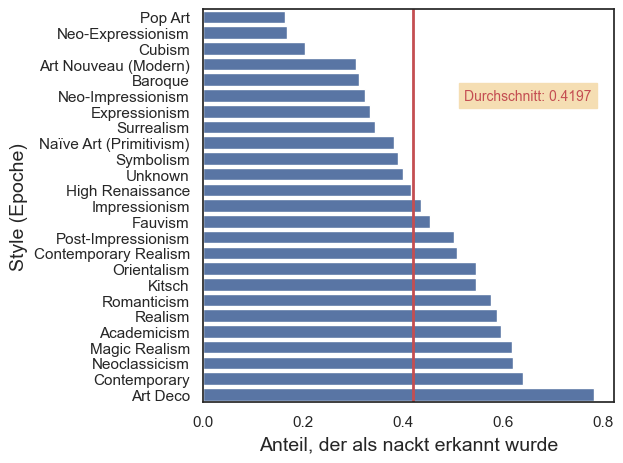

In [69]:
# Make Plot with seaborn
sns.set_style('white')
plot = (
    sns.barplot(data = df_plot, x = 'nude', y = 'style', orient = 'y',
                order = cross_table.index, errorbar = None)
    )

plot.axvline(x = 0.4197, color = 'r', linewidth = 2) # Line shows general proportion: 1759 / 4191 = 41.97%

# Fix font sizes
plot.set_xlabel('Anteil, der als nackt erkannt wurde', size = 14)
plot.set_ylabel('Style (Epoche)', size = 14)
plot.text(0.65, 5, 'Durchschnitt: 0.4197', 
       fontsize = 10,
       backgroundcolor = 'wheat',
       color = 'r',
       ha = 'center', # Horizontal alignment
       va = 'center')

# --> Above average (of the frequent styles) are: Academicism, Romanticism, Realism, Impressionism, 
# Post-Impressionism, Kitsch, Fauvism, Contemporary Realism
figure = plot.get_figure()
figure.tight_layout()
#figure.savefig('../../out/nude_paintings_style.png')